In [12]:
import matplotlib.pyplot as plt        
import numpy as np                      
import pandas as pd                    
from scipy.optimize import curve_fit   
import scipy.optimize as op
from scipy.signal import find_peaks
import requests

ModuleNotFoundError: No module named 'requests'

In [11]:
url = 'https://zenodo.org/records/18484599/files/wave0.txt'

r = requests.get(url)
print("HTTP status:", r.status_code)
print("Content-Type:", r.headers.get("Content-Type"))
print("First 200 chars:\n", r.text[:200])

prefix = "ch1_"
max_events = 100000 # larger than dataset 
#header_lines = 7 # or None for all
samples = 1024 # samples per waveform 

# Stream and process
response = requests.get(url, stream=True) # starts streaming file line by line, stream = True means dont load everything to memory at once
response.raise_for_status() # raises error if something fails

NameError: name 'requests' is not defined

In [10]:
data = []
with open('gammalong.txt') as f:
    for line in f:
        line = line.strip()
        if line.isdigit():
            data.append(int(line))
arr = np.array(data)



record_length = 256
waveforms = len(data) // record_length


Pulses = arr.reshape(waveforms, record_length)


#250 million samples per second, sorting x axis

samples = 250*10**6
time = 1/samples * 1*10**(9)


time_axis = np.arange(record_length) * time

#converting y axis 

adc_levels = 2**12       
vpp = 2.0                      
midpoint = adc_levels / 2      
Pulses_volts = (Pulses.astype(np.float32) - midpoint) * (vpp / adc_levels)


baseline_samples_start = 30  
baseline_samples_end = 80   

start_region = Pulses_volts[:, :baseline_samples_start]
end_region   = Pulses_volts[:, -baseline_samples_end:]

baseline_vals = np.mean(
    np.concatenate((start_region, end_region), axis=1),
    axis=1
)

Pulses_corrected = Pulses_volts - baseline_vals[:, np.newaxis]



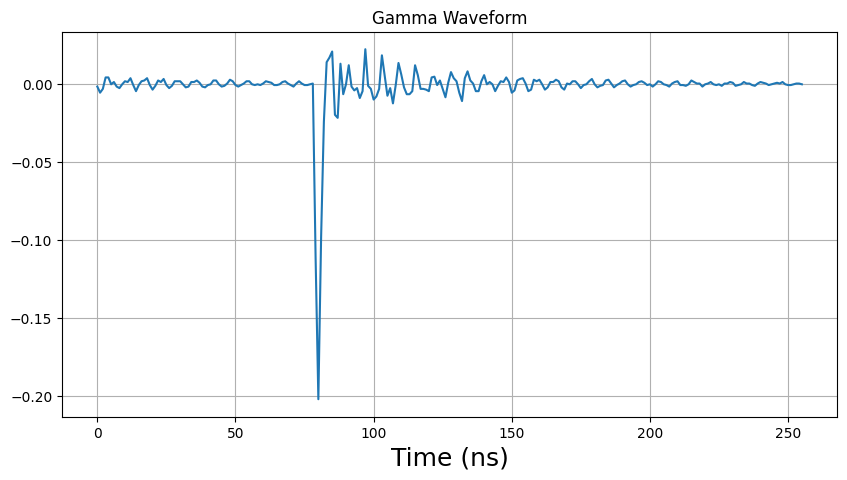

In [6]:
plt.figure(figsize=(10,5))

idc = 12

plt.plot(Pulses_corrected[idc])
plt.xlabel("Time (ns)", size = 18)
#plt.xlim(350, 1100)
plt.title('Gamma Waveform')
plt.grid(True)
plt.show()

# FIRST AMPLITUDE SPECTRUMS

NameError: name 'pulse_amplitudes2' is not defined

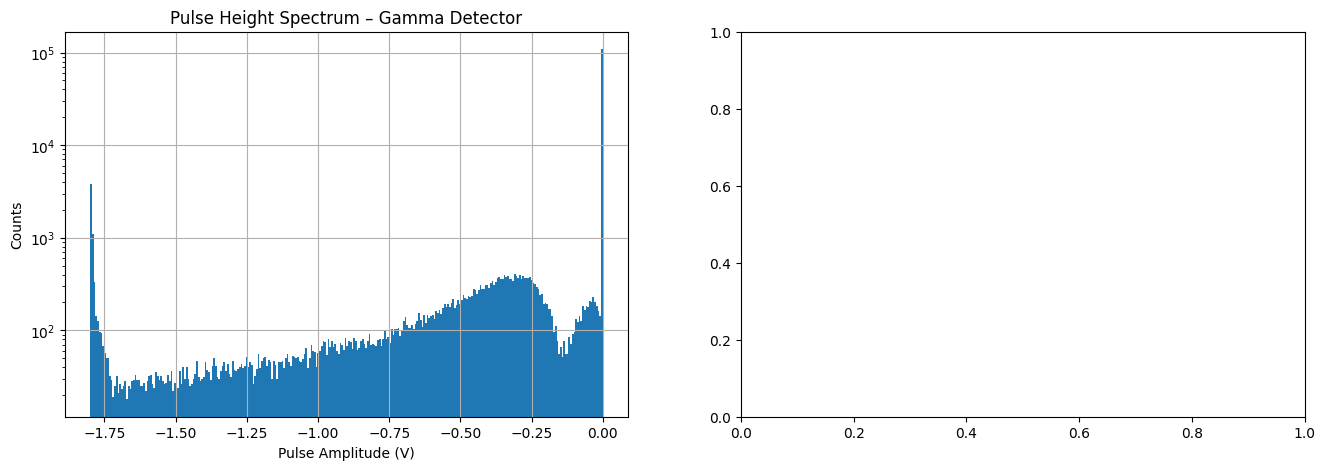

In [8]:
plt.figure(figsize=(16,5))


plt.subplot(1, 2, 1)
pulse_amplitudes = np.min(Pulses_corrected, axis=1)
plt.hist(pulse_amplitudes, bins=300)
plt.xlabel("Pulse Amplitude (V)")
plt.ylabel("Counts")
plt.title("Pulse Height Spectrum – Gamma Detector")
plt.yscale("log")
plt.grid(True)


plt.subplot(1, 2, 2)
plt.hist(pulse_amplitudes2, bins=300)
plt.xlabel("Pulse Amplitude (V)")
plt.ylabel("Counts")
plt.title("Pulse Height Spectrum – Alpha Detector")
plt.yscale("log")
plt.grid(True)

plt.tight_layout()
plt.show()


# SECOND AMPLITUDE SPECTRUMS

-0.0079194615


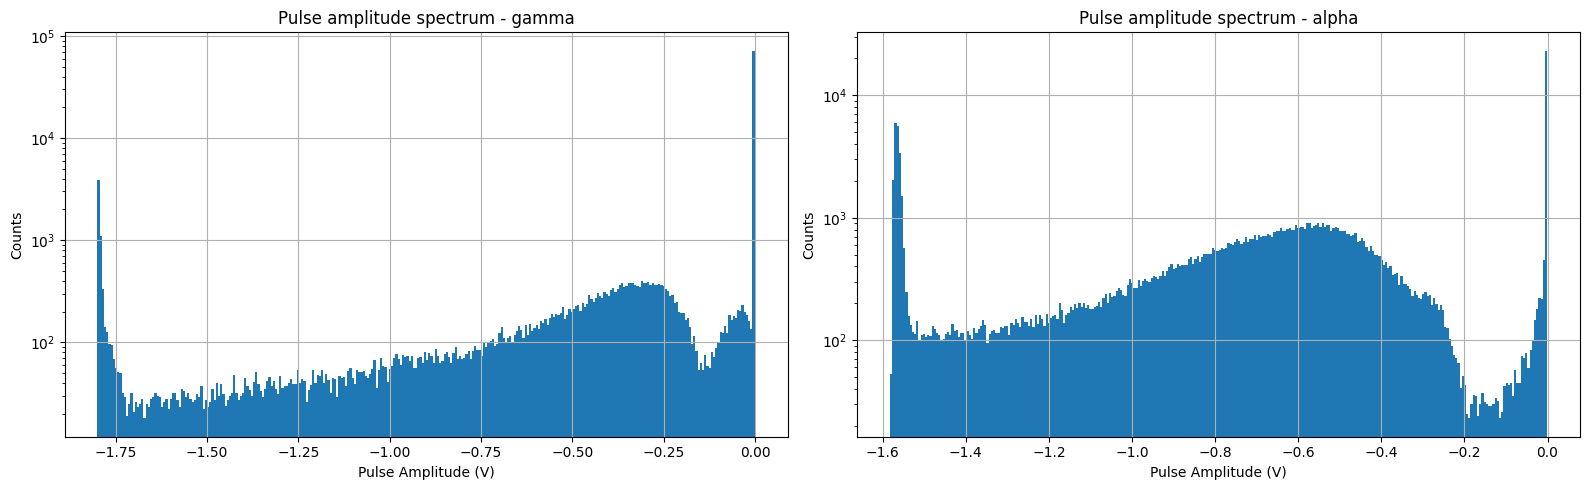

In [ ]:
plt.figure(figsize=(16,5))
#cut
#gamma snr plot

plt.subplot(1, 2, 1)


baseline_region_1 = np.concatenate((Pulses_corrected[:, :baseline_samples_start], 
                                     Pulses_corrected[:, -baseline_samples_end:]), axis=1)


noiserms = np.std(baseline_region_1, axis=1)

snr1 = np.abs(pulse_amplitudes) / noiserms

valid = pulse_amplitudes < -3 * noiserms
valid_pulses = pulse_amplitudes[valid]

plt.hist(valid_pulses, bins=300)
plt.xlabel("Pulse Amplitude (V)")
plt.ylabel("Counts")
plt.title(f"Pulse amplitude spectrum - gamma")
plt.yscale("log")
plt.grid(True)


#alpha snr plot


plt.subplot(1, 2, 2)


baseline_region2 = np.concatenate((Pulses_corrected2[:, :baseline_samples_start], 
                                    Pulses_corrected2[:, -baseline_samples_end:]), axis=1)
noiserms2 = np.std(baseline_region2, axis=1)
snr2 = np.abs(pulse_amplitudes2) / noiserms2
snrthres2 = snr2 > 3
valid_pulses2 = pulse_amplitudes2[snrthres2]

plt.hist(valid_pulses2, bins=300)
plt.xlabel("Pulse Amplitude (V)")
plt.ylabel("Counts")
plt.title(f"Pulse amplitude spectrum - alpha")
plt.yscale("log")
plt.grid(True)


fixedthres = np.mean(-noiserms2) 
print(fixedthres)

plt.tight_layout()
plt.show()

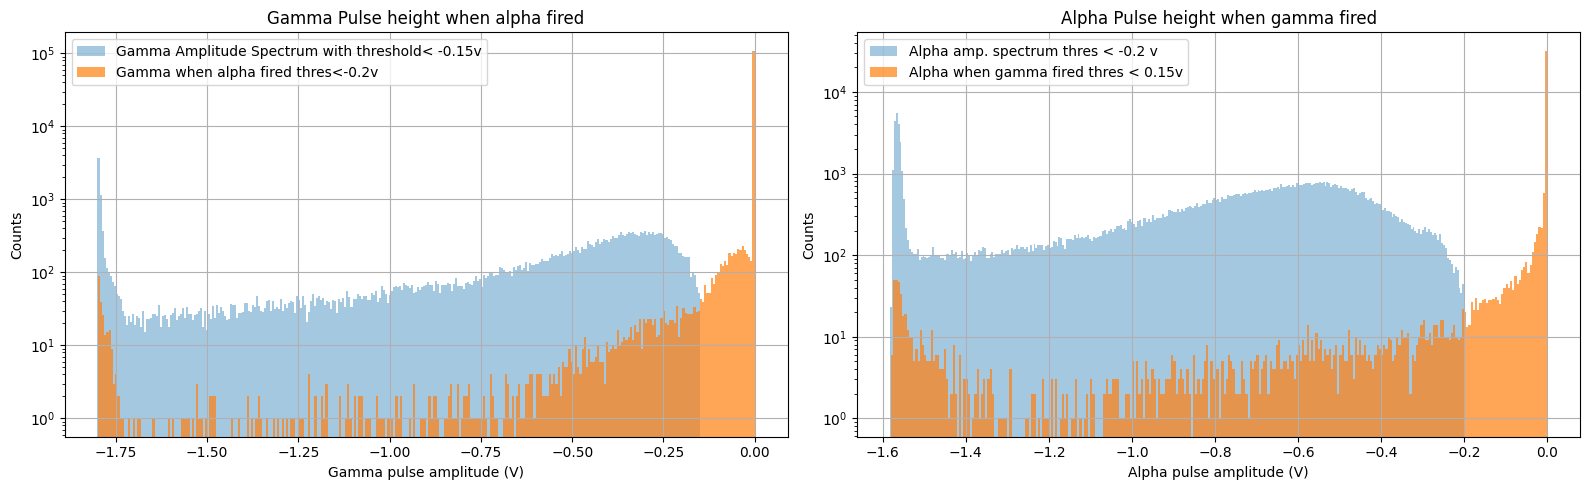

In [219]:

gamma_thr = -0.15
alpha_thr = -0.20

gammatriggered = pulse_amplitudes < gamma_thr
alphatriggered = pulse_amplitudes2 < alpha_thr

plt.figure(figsize=(16,5))

#gamma spec when alpha fired
plt.subplot(1, 2, 1)

plt.hist(
    pulse_amplitudes[gammatriggered],
    bins=300,
    alpha=0.4,
    label="Gamma Amplitude Spectrum with threshold< -0.15v"
)

plt.hist(
    pulse_amplitudes[alphatriggered],
    bins=300,
    alpha=0.7,
    label="Gamma when alpha fired thres<-0.2v"
)

plt.xlabel("Gamma pulse amplitude (V)")
plt.ylabel("Counts")
plt.title('Gamma Pulse height when alpha fired')
plt.yscale("log")
plt.legend()
plt.grid(True)

#alpha pulse height when gam fired

plt.subplot(1, 2, 2)

plt.hist(
    pulse_amplitudes2[alphatriggered],
    bins=300,
    alpha=0.4,
    label="Alpha amp. spectrum thres < -0.2 v"
)

plt.hist(
    pulse_amplitudes2[gammatriggered],
    bins=300,
    alpha=0.7,
    label="Alpha when gamma fired thres < 0.15v"
)

plt.xlabel("Alpha pulse amplitude (V)")
plt.ylabel("Counts")
plt.title('Alpha Pulse height when gamma fired')
plt.yscale("log")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

coindice timing with and without conditions

WITH:

In [157]:
valid_gamma = []
valid_gamma_time = []

for i, waveform in enumerate(Pulses_corrected):

    peaks, _ = find_peaks(-waveform, height=0.15, distance=25)

    if len(peaks) > 0:
        peak_sample = peaks[np.argmax(_["peak_heights"])]
        peak_time = time_axis[peak_sample]

        valid_gamma.append(i)
        valid_gamma_time.append(peak_time)

print(valid_gamma_time)

[np.float64(312.0), np.float64(312.0), np.float64(320.0), np.float64(320.0), np.float64(312.0), np.float64(316.0), np.float64(308.0), np.float64(320.0), np.float64(316.0), np.float64(312.0), np.float64(308.0), np.float64(280.0), np.float64(308.0), np.float64(312.0), np.float64(312.0), np.float64(312.0), np.float64(320.0), np.float64(308.0), np.float64(308.0), np.float64(324.0), np.float64(316.0), np.float64(320.0), np.float64(264.0), np.float64(312.0), np.float64(308.0), np.float64(316.0), np.float64(256.0), np.float64(324.0), np.float64(308.0), np.float64(320.0), np.float64(316.0), np.float64(308.0), np.float64(320.0), np.float64(288.0), np.float64(320.0), np.float64(308.0), np.float64(272.0), np.float64(312.0), np.float64(308.0), np.float64(264.0), np.float64(312.0), np.float64(320.0), np.float64(316.0), np.float64(320.0), np.float64(316.0), np.float64(292.0), np.float64(320.0), np.float64(660.0), np.float64(260.0), np.float64(264.0), np.float64(272.0), np.float64(308.0), np.float64(

numbers in text files 37867776
number of waveforms in text file =  147921


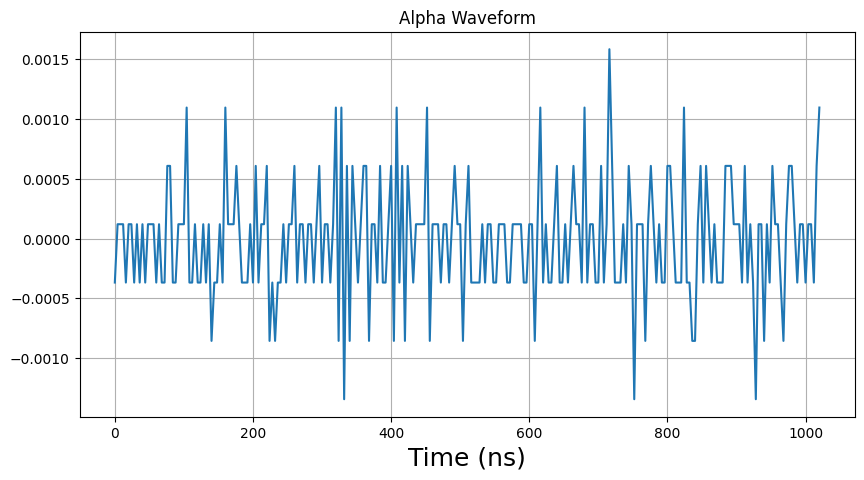

In [5]:
data2 = []
with open('alphalong.txt') as f:
    for line in f:
        line = line.strip()
        if line.isdigit():
            data2.append(int(line))
arr2 = np.array(data2)

print("numbers in text files", len(data2))

record_length = 256  
waveforms = len(data2) // record_length
print('number of waveforms in text file = ',waveforms)

Pulses2 = arr2.reshape(waveforms, record_length)


waveform = Pulses2[0]

#250 million samples per second

samples = 250*10**6
time = 1/samples * 1*10**(9)


time_axis = np.arange(record_length) * time

adc_levels = 2**12       
vpp = 2.0                      
midpoint = adc_levels / 2      
Pulses_volts2 = (Pulses2.astype(np.float32) - midpoint) * (vpp / adc_levels)
#do start and end
baseline_samples_start = 30  # 0-120 ns
baseline_samples_end = 100   # last 400 ns

start_region2 = Pulses_volts2[:, :baseline_samples_start]
end_region2   = Pulses_volts2[:, -baseline_samples_end:]

baseline_vals2 = np.mean(
    np.concatenate((start_region2, end_region2), axis=1),
    axis=1
)

Pulses_corrected2 = Pulses_volts2 - baseline_vals2[:, np.newaxis]


ind=3
plt.figure(figsize=(10,5))
plt.plot(time_axis, Pulses_corrected2[ind])
plt.xlabel("Time (ns)", size = 18)
#plt.xlim(1600, 2500)
plt.title('Alpha Waveform')
plt.grid(True)
plt.show()

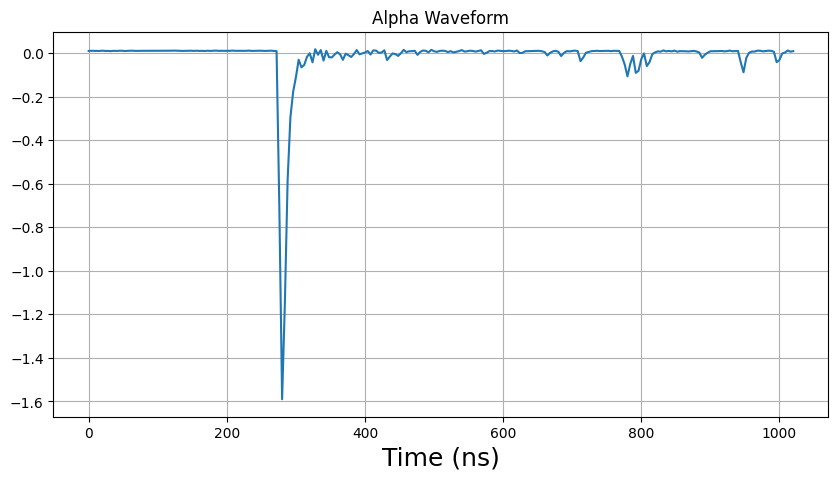

In [56]:
ind=30
plt.figure(figsize=(10,5))
plt.plot(time_axis, Pulses_corrected2[ind])
plt.xlabel("Time (ns)", size = 18)
#plt.xlim(1600, 2500)
plt.title('Alpha Waveform')
plt.grid(True)
plt.show()

In [163]:
valid_alpha = []
valid_alpha_time = []

for i, waveform in enumerate(Pulses_corrected2):
    peaks, _ = find_peaks(-waveform, height=0.2, distance=50)

    if len(peaks) > 0:
        peak_sample = peaks[np.argmax(_["peak_heights"])]              
        peak_time = time_axis[peak_sample]   

        valid_alpha.append(i)          
        valid_alpha_time.append(peak_time)   


print(valid_alpha_time)

[np.float64(264.0), np.float64(292.0), np.float64(280.0), np.float64(276.0), np.float64(272.0), np.float64(296.0), np.float64(300.0), np.float64(292.0), np.float64(272.0), np.float64(300.0), np.float64(156.0), np.float64(312.0), np.float64(288.0), np.float64(292.0), np.float64(300.0), np.float64(288.0), np.float64(300.0), np.float64(288.0), np.float64(276.0), np.float64(300.0), np.float64(292.0), np.float64(268.0), np.float64(300.0), np.float64(300.0), np.float64(288.0), np.float64(280.0), np.float64(296.0), np.float64(284.0), np.float64(284.0), np.float64(292.0), np.float64(292.0), np.float64(292.0), np.float64(300.0), np.float64(280.0), np.float64(292.0), np.float64(292.0), np.float64(288.0), np.float64(300.0), np.float64(300.0), np.float64(296.0), np.float64(292.0), np.float64(288.0), np.float64(292.0), np.float64(284.0), np.float64(296.0), np.float64(208.0), np.float64(296.0), np.float64(284.0), np.float64(300.0), np.float64(268.0), np.float64(300.0), np.float64(284.0), np.float64(

In [193]:
alpha_time = dict(zip(valid_alpha, valid_alpha_time))
gamma_time = dict(zip(valid_gamma, valid_gamma_time))

window_ns = 300 

coincidences = []
dt_values = []

for i in range(len(Pulses_corrected)):
    if i in alpha_time and i in gamma_time:

        dt = gamma_time[i] - alpha_time[i]   

        if 0 < dt < window_ns:               
            dt_values.append(dt)
            coincidences.append(i)

print("Coincident waveforms:", coincidences)

print(len(dt_values))


Coincident waveforms: [238, 746, 778, 818, 819, 826, 967, 1206, 1235, 1243, 1256, 1373, 1634, 1704, 1825, 1843, 1863, 2720, 2773, 2804, 3038, 3047, 3237, 3245, 3459, 3478, 3484, 3656, 4487, 4541, 4667, 4696, 5068, 5096, 5167, 5390, 5531, 5679, 5694, 5715, 5775, 5830, 5970, 6173, 6235, 6570, 7027, 7046, 7252, 7618, 7673, 7711, 7805, 7848, 7850, 8152, 8235, 8262, 8270, 8378, 8503, 8519, 8583, 8645, 8655, 8667, 8836, 8928, 8997, 9103, 9490, 9595, 9672, 9943, 10180, 10530, 10547, 10636, 10782, 11052, 11115, 11193, 11295, 11390, 11415, 11468, 11498, 11513, 11582, 11666, 11699, 11800, 11875, 12011, 12144, 12171, 12245, 12382, 12477, 12644, 12770, 12966, 13170, 13178, 13235, 13424, 13525, 13535, 13560, 13591, 13707, 13718, 13993, 14015, 14836, 14997, 15288, 15505, 15535, 15914, 15957, 16021, 16091, 16113, 16183, 16194, 16323, 16335, 16363, 16442, 16512, 16573, 16718, 16735, 16741, 16762, 16825, 16839, 17096, 17262, 17284, 17321, 17550, 17644, 17676, 17683, 17685, 17698, 17909, 18044, 18070, 1

# TIME DIFFERENCE PLOTS

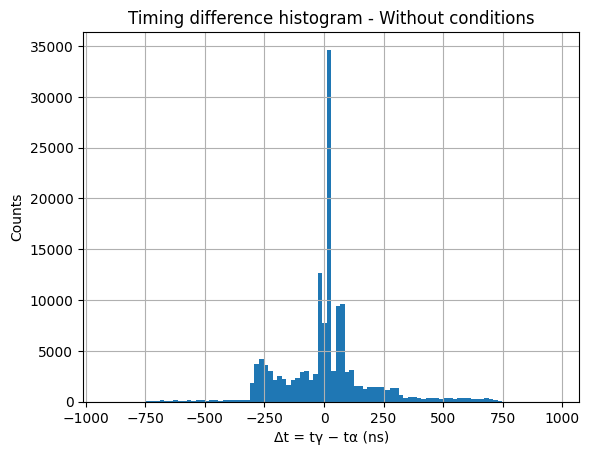

In [226]:
gamma_time = []
alpha_time = []

for waveform in Pulses_corrected:
    peak_sample = np.argmin(waveform)  
    gamma_time.append(time_axis[peak_sample])

for waveform in Pulses_corrected2:
    peak_sample = np.argmin(waveform)
    alpha_time.append(time_axis[peak_sample])

dt_valuesnc = []

for i in range(min(len(gamma_time), len(alpha_time))):
    dt = gamma_time[i] - alpha_time[i]
    dt_valuesnc.append(dt)

plt.figure()
plt.hist(dt_valuesnc, bins=100)
plt.xlabel("Δt = tγ − tα (ns)")
plt.ylabel("Counts")
plt.title("Timing difference histogram - Without conditions")
plt.grid()
plt.show()

In [220]:
alpha_time = dict(zip(valid_alpha, valid_alpha_time))
gamma_time = dict(zip(valid_gamma, valid_gamma_time))

window_ns = 300

dt_values = []

for i in alpha_time:
    if i in gamma_time:
        dt = gamma_time[i] - alpha_time[i]

        if 0 < dt < window_ns:
            dt_values.append(dt)

dt_values = np.array(dt_values)

print("Number of coincidences:", len(dt_values))

Number of coincidences: 1309


τ = 69.14 ± 12.36 ns


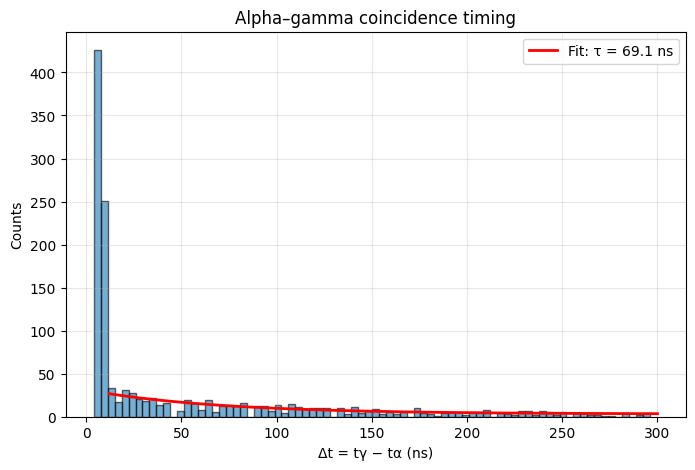

In [ ]:
bins = 80
counts, bin_edges = np.histogram(dt_values, bins=bins)
bin_centres = 0.5 * (bin_edges[:-1] + bin_edges[1:])

def exp_bg(t, A, tau, bg):
    return A * np.exp(-t / tau) + bg

t_min_fit = 12
t_max_fit = 300

mask = (
    (bin_centres > t_min_fit) &
    (bin_centres < t_max_fit) &
    (counts > 0)
)

x_fit = bin_centres[mask]
y_fit = counts[mask]
#y_err= np.sqrt(counts)

p0 = (y_fit.max(), 100, y_fit.min())

popt, pcov = curve_fit(exp_bg, x_fit, y_fit, p0=p0) #pass errors through data points, 

A_fit, tau_fit, bg_fit = popt
tau_err = np.sqrt(pcov[1, 1])

print(f"τ = {tau_fit:.2f} ± {tau_err:.2f} ns")

plt.figure(figsize=(8,5))

plt.bar(
    bin_centres,
    counts,
    width=bin_edges[1] - bin_edges[0],
    alpha=0.6,
    edgecolor="black"
)

t_plot = np.linspace(t_min_fit, t_max_fit, 400)

plt.plot(
    t_plot,
    exp_bg(t_plot, A_fit, tau_fit, bg_fit),
    'r',
    linewidth=2,
    label=f"Fit: τ = {tau_fit:.1f} ns"
)

plt.xlabel("Δt = tγ − tα (ns)")
plt.ylabel("Counts")
plt.title("Alpha–gamma coincidence timing")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# PULSE HEIGHT VS TIME PLOTS

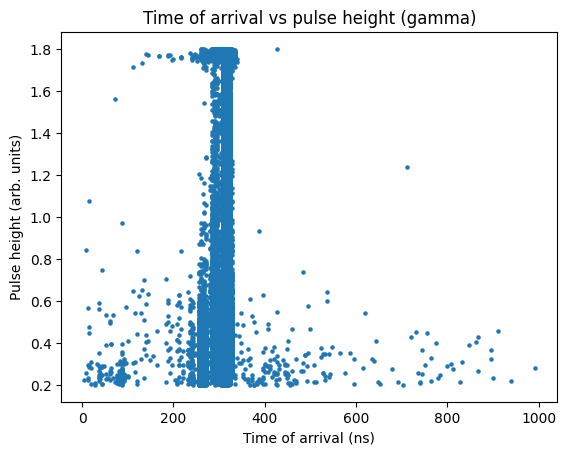

In [186]:
gamma_times = []
gamma_heights = []

for waveform in Pulses_corrected:
    peaks, _ = find_peaks(-waveform, height=0.2, distance=25)

    if len(peaks) > 0:
        peak_sample = peaks[0]
        peak_time = time_axis[peak_sample]
        peak_height = abs(waveform[peak_sample])

        gamma_times.append(peak_time)
        gamma_heights.append(peak_height)

plt.figure()
plt.scatter(gamma_times, gamma_heights, s=5)
plt.xlabel("Time of arrival (ns)")
plt.ylabel("Pulse height (arb. units)")
plt.title("Time of arrival vs pulse height (gamma)")
plt.show()


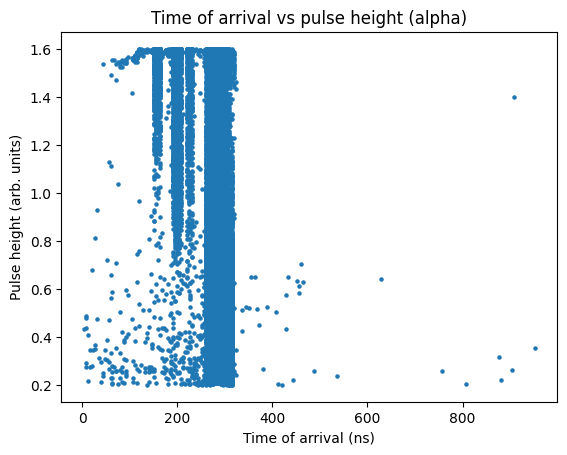

In [103]:
alpha_times = []
alpha_heights = []

for waveform in Pulses_corrected2:
    peaks, _ = find_peaks(-waveform, height=0.2, distance=50)

    if len(peaks) > 0:
        peak_sample = peaks[0]
        peak_time = time_axis[peak_sample]
        peak_height = abs(waveform[peak_sample])

        alpha_times.append(peak_time)
        alpha_heights.append(peak_height)
plt.figure()
plt.scatter(alpha_times, alpha_heights, s=5)
plt.xlabel("Time of arrival (ns)")
plt.ylabel("Pulse height (arb. units)")
plt.title("Time of arrival vs pulse height (alpha)")
plt.show()

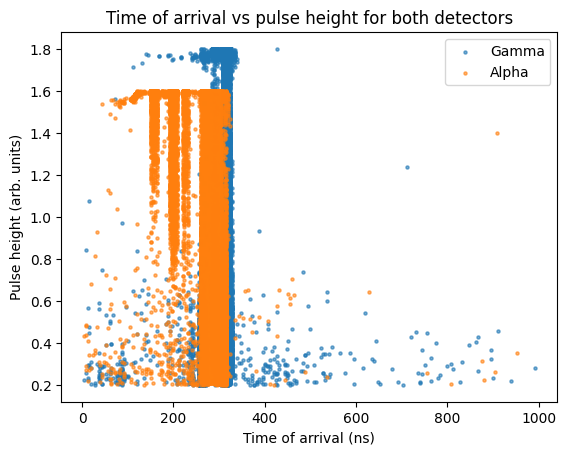

In [105]:
plt.figure()

plt.scatter(gamma_times, gamma_heights, s=5, label="Gamma", alpha=0.6)
plt.scatter(alpha_times, alpha_heights, s=5, label="Alpha", alpha=0.6)

plt.xlabel("Time of arrival (ns)")
plt.ylabel("Pulse height (arb. units)")
plt.title("Time of arrival vs pulse height for both detectors")
plt.legend()
plt.show()


# PULSE HEIGHT - COMPARING DETECTORS

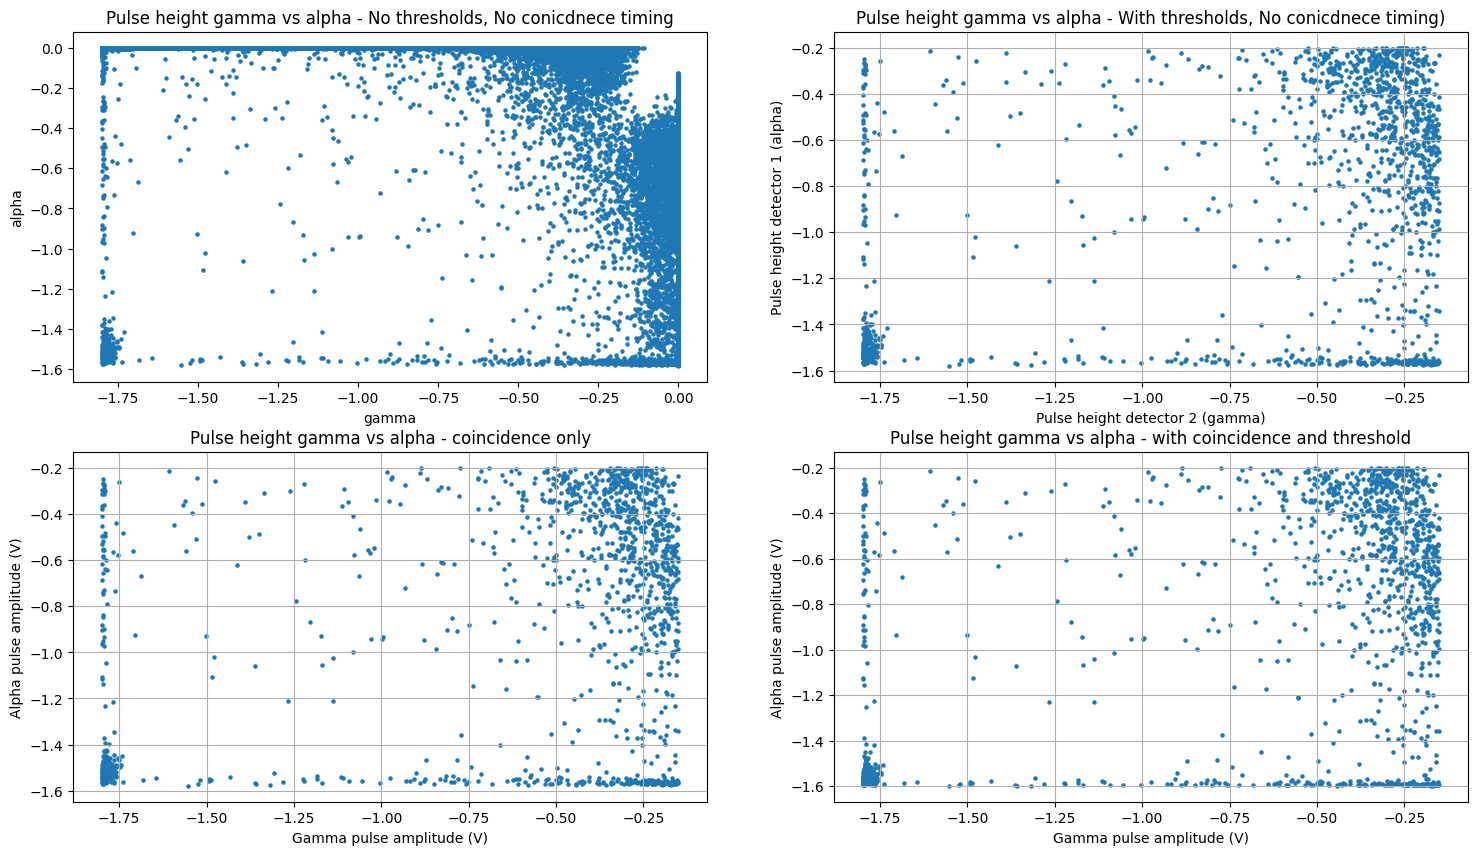

In [242]:
plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
plt.scatter(pulse_amplitudes,pulse_amplitudes2, s=5)
plt.xlabel('gamma')
plt.ylabel('alpha')
plt.title("Pulse height gamma vs alpha - No thresholds, No conicdnece timing")




gamma_thresh = -0.15
alpha_thresh = -0.2


x = []  
y = [] 

for g, a in zip(pulse_amplitudes, pulse_amplitudes2):
    if g < gamma_thresh and a < alpha_thresh:
        x.append(g)
        y.append(a)


plt.subplot(2,2,2)
plt.scatter(x, y, s=5)
plt.xlabel("Pulse height detector 2 (gamma)")
plt.ylabel("Pulse height detector 1 (alpha)")
plt.grid()
plt.title("Pulse height gamma vs alpha - With thresholds, No conicdnece timing)")


plt.subplot(2,2,3) 
plt.scatter(
    pulse_amplitudes[coincidences],
    pulse_amplitudes2[coincidences],
    s=5,
)

plt.xlabel("Gamma pulse amplitude (V)")
plt.ylabel("Alpha pulse amplitude (V)")
plt.title(f"Pulse height gamma vs alpha - coincidence only")
plt.grid(True)
plt.subplot(2,2,4)
mask = (
    (pulse_min_1[coincidences] < -0.15) &
    (pulse_min_2[coincidences] < -0.20)
)



plt.scatter(
    pulse_min_1[coincidences][mask],
    pulse_min_2[coincidences][mask],
    s=5
)

plt.xlabel("Gamma pulse amplitude (V)")
plt.ylabel("Alpha pulse amplitude (V)")
plt.title("Pulse height gamma vs alpha - with coincidence and threshold")
plt.grid(True)
plt.show()


In [ ]:
window_ns = 300

dt_values = []
coincidences = []

for i in range(len(Pulses_corrected)):  # gamma channel waveforms
    wf_g = Pulses_corrected[i]          # gamma waveform (negative-going)
    wf_a = Pulses_corrected2[i]         # alpha waveform (negative-going)

    # Find alpha peak (pick the biggest alpha pulse in that trace)
    a_peaks, a_props = find_peaks(-wf_a, height=0.2, distance=50)
    if len(a_peaks) == 0:
        continue

    # Choose the strongest alpha peak (not just first)
    a_best = a_peaks[np.argmax(a_props["peak_heights"])]
    t_alpha = time_axis[a_best]

    # Find ALL gamma peaks in that same trace
    g_peaks, g_props = find_peaks(-wf_g, height=0.2, distance=25)
    if len(g_peaks) == 0:
        continue

    # Consider only gammas after alpha within the window
    best_gamma_height = None
    best_dt = None

    for gp, gh in zip(g_peaks, g_props["peak_heights"]):
        t_gamma = time_axis[gp]
        dt = t_gamma - t_alpha

        if 0 < dt < window_ns:
            if best_gamma_height is None or gh > best_gamma_height:
                best_gamma_height = gh
                best_dt = dt

    if best_dt is not None:
        dt_values.append(best_dt)
        coincidences.append(i)

dt_values = np.array(dt_values)

print("Coincidences found:", len(dt_values))
print("dt min/max:", dt_values.min() if len(dt_values) else None,
                  dt_values.max() if len(dt_values) else None)

Coincidences found: 1108
dt min/max: 4.0 296.0


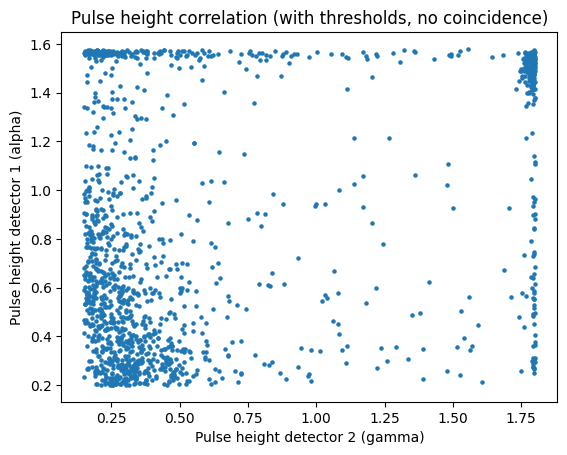

In [135]:

gamma_thresh = 0.15
alpha_thresh = 0.2


x = []  
y = [] 

for g, a in zip(-pulse_amplitudes, -pulse_amplitudes2):
    if g > gamma_thresh and a > alpha_thresh:
        x.append(g)
        y.append(a)


plt.figure()
plt.scatter(x, y, s=5)
plt.xlabel("Pulse height detector 2 (gamma)")
plt.ylabel("Pulse height detector 1 (alpha)")
plt.title("Pulse height correlation (with thresholds, no coincidence)")
plt.show()


In [243]:
valid_gamma2 = []
valid_gamma_time2 = []

for i, waveform in enumerate(Pulses_corrected):
    peaks, props = find_peaks(-waveform, height=None, distance=25)  # no amplitude threshold
    if len(peaks) > 0:
        ps = peaks[np.argmax(props["peak_heights"])]
        valid_gamma2.append(i)
        valid_gamma_time2.append(time_axis[ps])

valid_alpha2 = []
valid_alpha_time2 = []

for i, waveform in enumerate(Pulses_corrected2):
    peaks, props = find_peaks(-waveform, height=None, distance=50)  # no amplitude threshold
    if len(peaks) > 0:
        ps = peaks[np.argmax(props["peak_heights"])]
        valid_alpha2.append(i)
        valid_alpha_time2.append(time_axis[ps])

KeyError: 'peak_heights'

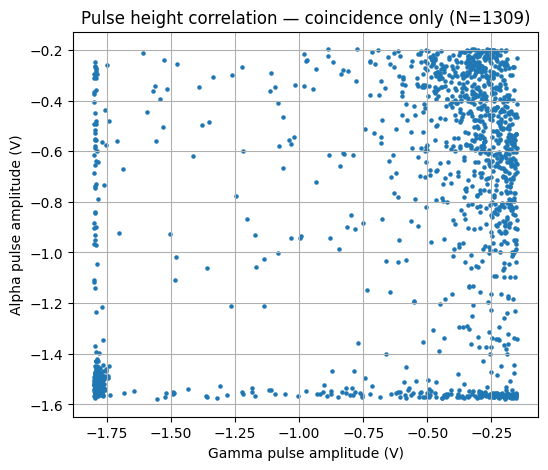

In [232]:
plt.figure(figsize=(6,5))

plt.scatter(
    pulse_amplitudes[coincidences],
    pulse_amplitudes2[coincidences],
    s=5,
)

plt.xlabel("Gamma pulse amplitude (V)")
plt.ylabel("Alpha pulse amplitude (V)")
plt.title(f"Pulse height correlation — coincidence only (N={len(coincidences)})")
plt.grid(True)
plt.show()



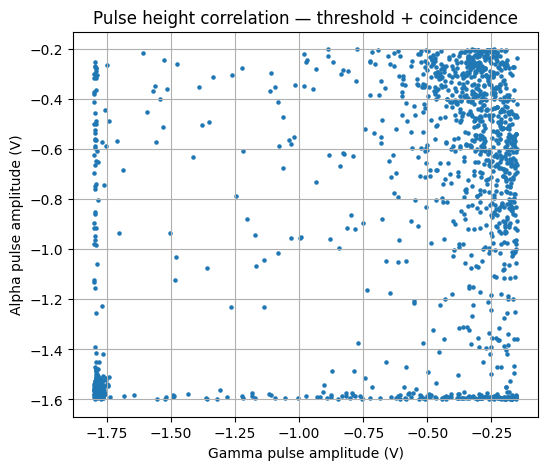

In [234]:
mask = (
    (pulse_min_1[coincidences] < -0.15) &
    (pulse_min_2[coincidences] < -0.20)
)

plt.figure(figsize=(6,5))

plt.scatter(
    pulse_min_1[coincidences][mask],
    pulse_min_2[coincidences][mask],
    s=5
)

plt.xlabel("Gamma pulse amplitude (V)")
plt.ylabel("Alpha pulse amplitude (V)")
plt.title("Pulse height correlation — threshold + coincidence")
plt.grid(True)
plt.show()

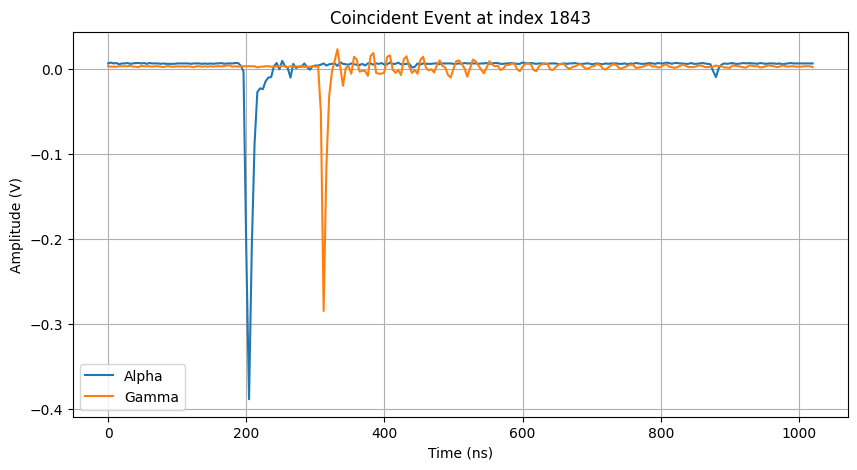

In [81]:
i = coincidences[11]     

alpha_wave = Pulses_corrected2[i]
gamma_wave = Pulses_corrected[i]

plt.figure(figsize=(10,5))
plt.plot(time_axis, alpha_wave, label="Alpha")
plt.plot(time_axis, gamma_wave, label="Gamma")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude (V)")
plt.title(f"Coincident Event at index {i}")
plt.legend()
#plt.xlim(500,900)
plt.grid(True)
plt.show()

In [195]:
print(f"Total coincidences: {len(coincidences)}")
print("\nFirst 10 coincidences:")
for idx in coincidences[:10]:
    print(f"Index {idx}: alpha_time = {alpha_time[idx]:.1f} ns, gamma_time = {gamma_time[idx]:.1f} ns, dt = {gamma_time[idx] - alpha_time[idx]:.1f} ns")

Total coincidences: 1309

First 10 coincidences:
Index 238: alpha_time = 288.0 ns, gamma_time = 292.0 ns, dt = 4.0 ns
Index 746: alpha_time = 304.0 ns, gamma_time = 312.0 ns, dt = 8.0 ns
Index 778: alpha_time = 256.0 ns, gamma_time = 260.0 ns, dt = 4.0 ns
Index 818: alpha_time = 200.0 ns, gamma_time = 236.0 ns, dt = 36.0 ns
Index 819: alpha_time = 304.0 ns, gamma_time = 312.0 ns, dt = 8.0 ns
Index 826: alpha_time = 316.0 ns, gamma_time = 320.0 ns, dt = 4.0 ns
Index 967: alpha_time = 212.0 ns, gamma_time = 264.0 ns, dt = 52.0 ns
Index 1206: alpha_time = 300.0 ns, gamma_time = 328.0 ns, dt = 28.0 ns
Index 1235: alpha_time = 240.0 ns, gamma_time = 320.0 ns, dt = 80.0 ns
Index 1243: alpha_time = 292.0 ns, gamma_time = 504.0 ns, dt = 212.0 ns


#dostributuon of signals to find dicrim value
#dataframe data
#look for alpha peak and around 300ns later is gamma
#amplitude distribution
#i think we plot all on same graph to find time window
#t-to in old experiment
#np.argmax or
#find peaks invert
#store pairs, when finding gamma and alpha
##pulse height prop to energy
#fidn peaks scipy
#hisotrgam for counts
#pulse integral vs height

alpha voltage = 2300
gamma voltage = 2003

In [ ]:
#STARTING CFD 

In [196]:

def cfd_time(waveform, time_axis, fraction=0.3, n_pre=50):

    baseline = np.mean(waveform[:n_pre])
    wf = waveform - baseline

    wf = -wf

    peak_idx = np.argmax(wf)
    peak_amp = wf[peak_idx]

    if peak_amp < 0.2:
        return None

    threshold = fraction * peak_amp

    
    for i in range(peak_idx):
        if wf[i] < threshold <= wf[i + 1]:
            t1 = time_axis[i]
            t2 = time_axis[i + 1]
            y1 = wf[i]
            y2 = wf[i + 1]

            return t1 + (threshold - y1) * (t2 - t1) / (y2 - y1)

    return None


In [197]:
valid_gamma_cfd = []
valid_gamma_time_cfd = []

for i, waveform in enumerate(Pulses_corrected):

    t_cfd = cfd_time(waveform, time_axis, fraction=0.3)

    if t_cfd is not None:
        valid_gamma_cfd.append(i)
        valid_gamma_time_cfd.append(t_cfd)

print(valid_gamma_time_cfd)

[np.float64(308.8574821405568), np.float64(309.1536989821601), np.float64(314.1821404172663), np.float64(316.14601441056976), np.float64(305.6598690672417), np.float64(313.02923317694035), np.float64(304.8032976891802), np.float64(317.18636637092044), np.float64(309.15995389754386), np.float64(309.1277869107668), np.float64(304.51336258217617), np.float64(277.15180430310835), np.float64(305.16359536889763), np.float64(305.67087939008223), np.float64(308.87023727352687), np.float64(307.839560904154), np.float64(316.9767012758204), np.float64(304.9953869088772), np.float64(302.5518911917788), np.float64(318.22658097853355), np.float64(307.4993107236665), np.float64(316.95973132734235), np.float64(257.9709443159706), np.float64(309.14959999367045), np.float64(304.65580554697624), np.float64(313.02809677278043), np.float64(317.5105230042268), np.float64(305.16987542468854), np.float64(317.0605018096158), np.float64(311.05440226295025), np.float64(302.8712133188717), np.float64(315.32167414

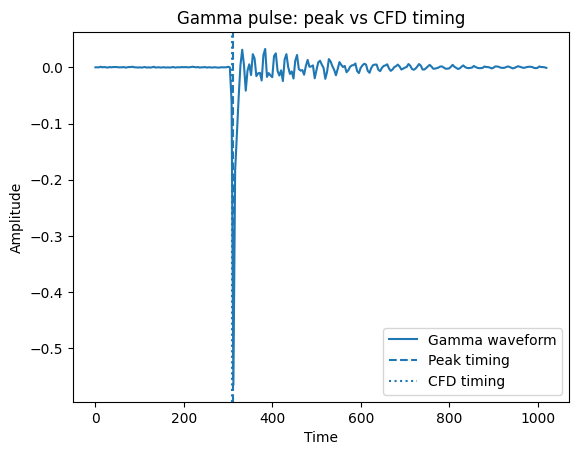

In [198]:
idx = valid_gamma[0]
waveform = Pulses_corrected[idx]

peak_sample = np.argmax(-waveform)
t_peak = time_axis[peak_sample]
t_cfd = cfd_time(waveform, time_axis, fraction=0.3)

plt.figure()
plt.plot(time_axis, waveform, label="Gamma waveform")
plt.axvline(t_peak, linestyle="--", label="Peak timing")
plt.axvline(t_cfd, linestyle=":", label="CFD timing")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Gamma pulse: peak vs CFD timing")
plt.show()

In [199]:
valid_alpha_cfd = []
valid_alpha_time_cfd = []

for i, waveform in enumerate(Pulses_corrected2):

    t_cfd = cfd_time(waveform, time_axis, fraction=0.3)

    if t_cfd is not None:
        valid_alpha_cfd.append(i)
        valid_alpha_time_cfd.append(t_cfd)

print(valid_alpha_time_cfd)

[np.float64(257.6400278184364), np.float64(288.580969740302), np.float64(276.46571387490735), np.float64(270.78981318721065), np.float64(265.66593051401134), np.float64(292.6434015846896), np.float64(297.1542526624689), np.float64(287.4832713992097), np.float64(266.38335657206926), np.float64(297.06502773221683), np.float64(153.35081113354585), np.float64(309.1956812998323), np.float64(284.9523111979167), np.float64(287.0554229421714), np.float64(296.9577629390867), np.float64(283.1366509980562), np.float64(296.94625762076225), np.float64(284.7697820437463), np.float64(269.36488933157415), np.float64(296.7894176887874), np.float64(288.94712182076654), np.float64(261.5596686285895), np.float64(296.9119131905692), np.float64(296.7616800362723), np.float64(285.00252636642034), np.float64(274.66365781037706), np.float64(290.999884955317), np.float64(279.07760854867786), np.float64(279.33442023106875), np.float64(288.5737097444293), np.float64(288.0707396508751), np.float64(288.985450057983

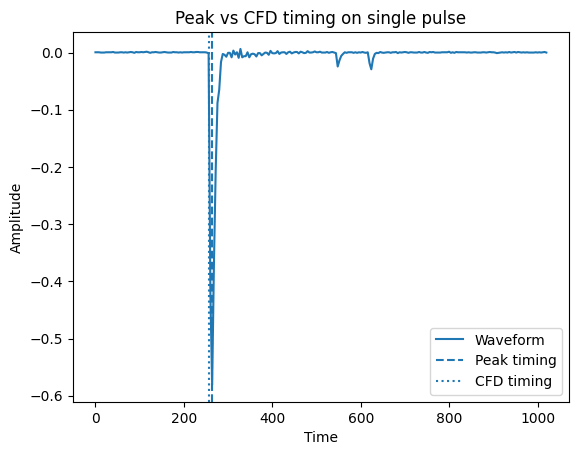

In [200]:
idx = valid_alpha[0]  # pick one valid event
waveform = Pulses_corrected2[idx]

# peak timing
peak_sample = np.argmax(-waveform)
t_peak = time_axis[peak_sample]

# CFD timing
t_cfd = cfd_time(waveform, time_axis, fraction=0.3)

plt.figure()
plt.plot(time_axis, waveform, label="Waveform")
plt.axvline(t_peak, linestyle="--", label="Peak timing")
plt.axvline(t_cfd, linestyle=":", label="CFD timing")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Peak vs CFD timing on single pulse")
plt.show()

In [201]:
alpha_time_cfd = dict(zip(valid_alpha_cfd, valid_alpha_time_cfd))
gamma_time_cfd = dict(zip(valid_gamma_cfd, valid_gamma_time_cfd))

coincidence_window_ns = 400

dt_cfd = []
coincident_indices_cfd = []

for i in range(len(Pulses_corrected)):
    if i in alpha_time_cfd and i in gamma_time_cfd:

        delta_t = gamma_time_cfd[i] - alpha_time_cfd[i]

        if 0 < delta_t < coincidence_window_ns:
            dt_cfd.append(delta_t)
            coincident_indices_cfd.append(i)

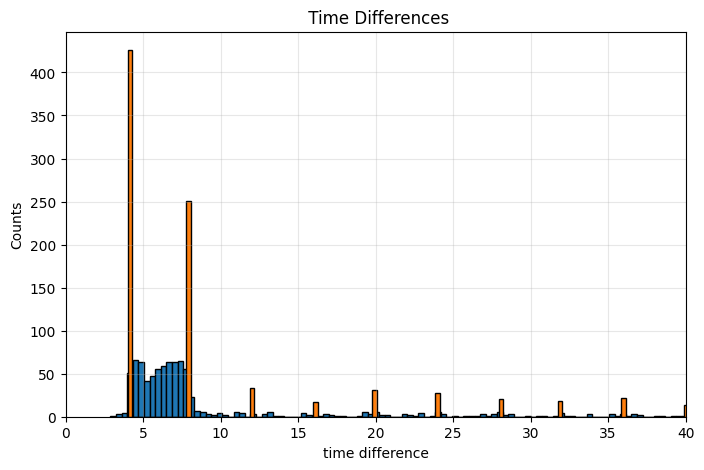

In [202]:
plt.figure(figsize=(8,5))
plt.hist(dt_cfd, bins=1000, edgecolor='black')
plt.hist(dt_values, bins=1000, edgecolor='black')
plt.xlabel("time difference")
plt.ylabel("Counts")
plt.title(" Time Differences")
plt.xlim(0,40)
plt.grid(True, alpha=0.3)
plt.show()

Fitted decay constant τ = 106.60 ± 10.32 ns


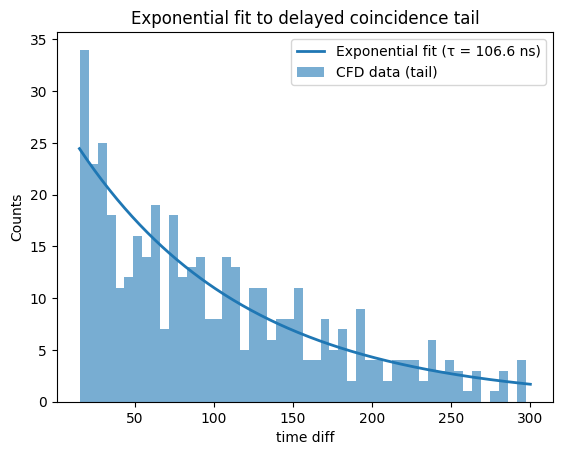

In [203]:

dt_cfd = np.array(dt_cfd)

t_min_fit = 15   
t_max_fit = 300   

dt_tail = dt_cfd[(dt_cfd > t_min_fit) & (dt_cfd < t_max_fit)]

bins = 50
counts, bin_edges = np.histogram(dt_tail, bins=bins)
bin_centres = 0.5 * (bin_edges[:-1] + bin_edges[1:])


mask = counts > 0
x_fit = bin_centres[mask]
y_fit = counts[mask]

def exponential(t, A, tau):
    return A * np.exp(-t / tau)

p0 = (y_fit.max(), 50)


popt, pcov = curve_fit(exponential, x_fit, y_fit, p0=p0)
A_fit, tau_fit = popt
tau_err = np.sqrt(pcov[1, 1])

print(f"Fitted decay constant τ = {tau_fit:.2f} ± {tau_err:.2f} ns")


plt.figure()
plt.bar(bin_centres, counts,
        width=bin_edges[1] - bin_edges[0],
        alpha=0.6, label="CFD data (tail)")

t_plot = np.linspace(t_min_fit, t_max_fit, 300)
plt.plot(t_plot, exponential(t_plot, A_fit, tau_fit),
         linewidth=2, label=f"Exponential fit (τ = {tau_fit:.1f} ns)")

plt.xlabel("time diff")
plt.ylabel("Counts")
plt.legend()
plt.title("Exponential fit to delayed coincidence tail")
plt.show()



CFD timing τ = 110.43 ± 10.67 ns


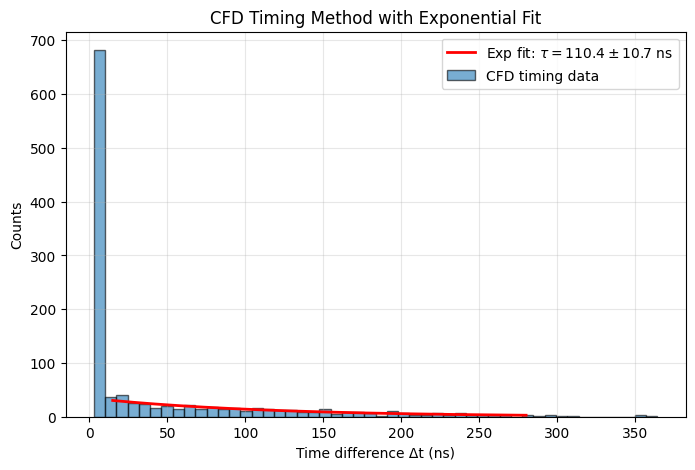

In [205]:
dt_values = np.array(dt_cfd)

counts, bin_edges = np.histogram(dt_values, bins=bins)
bin_centres = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# ---------- 2. Choose fit region ----------
t_min_fit = 15   # ns
t_max_fit = 280  # ns

mask = (bin_centres > t_min_fit) & (bin_centres < t_max_fit) & (counts > 0)

x_fit = bin_centres[mask]
y_fit = counts[mask]

# ---------- 3. Exponential model ----------
def exponential(t, A, tau):
    return A * np.exp(-t / tau)

p0 = (y_fit.max(), 100)

popt, pcov = curve_fit(exponential, x_fit, y_fit, p0=p0)
A_fit, tau_fit = popt
tau_err = np.sqrt(pcov[1, 1])

print(f"CFD timing τ = {tau_fit:.2f} ± {tau_err:.2f} ns")

# ---------- 4. Plot ----------
plt.figure(figsize=(8,5))

plt.bar(
    bin_centres,
    counts,
    width=bin_edges[1] - bin_edges[0],
    edgecolor='black',
    alpha=0.6,
    label="CFD timing data"
)

t_plot = np.linspace(t_min_fit, t_max_fit, 400)
plt.plot(
    t_plot,
    exponential(t_plot, A_fit, tau_fit),
    'r',
    linewidth=2,
    label=rf"Exp fit: $\tau = {tau_fit:.1f}\pm{tau_err:.1f}$ ns"
)

plt.xlabel("Time difference Δt (ns)")
plt.ylabel("Counts")
plt.title("CFD Timing Method with Exponential Fit")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


τ = 97.56 ± 22.67 ns
Background B = 0.51 counts/bin


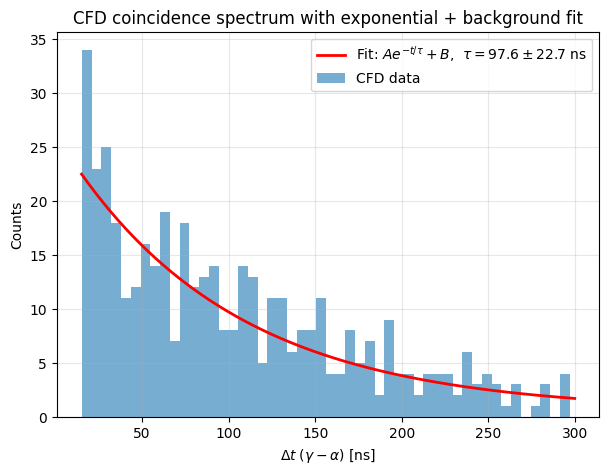

In [206]:
dt_cfd = np.array(dt_cfd)

# Fit window (adjust to your spectrum)
t_min_fit = 15    # ns  -> exclude prompt / detector response
t_max_fit = 300   # ns  -> upper fit limit

dt_tail = dt_cfd[(dt_cfd > t_min_fit) & (dt_cfd < t_max_fit)]

# -----------------------------
# Histogram
# -----------------------------
bins = 50
counts, bin_edges = np.histogram(dt_tail, bins=bins)
bin_centres = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Remove empty bins (important for fitting)
mask = counts > 0
x_fit = bin_centres[mask]
y_fit = counts[mask]

# Poisson uncertainties
sigma = np.sqrt(y_fit)

# -----------------------------
# Exponential + background model
# -----------------------------
def exponential_bg(t, A, tau, B):
    return A * np.exp(-t / tau) + B

# Initial parameter guesses
p0 = (
    y_fit.max(),   # A
    50,            # tau (ns)
    y_fit.min()    # B (background)
)

# -----------------------------
# Fit
# -----------------------------
popt, pcov = curve_fit(
    exponential_bg,
    x_fit,
    y_fit,
    p0=p0,
    sigma=sigma,
    absolute_sigma=True
)

A_fit, tau_fit, B_fit = popt
tau_err = np.sqrt(pcov[1, 1])

print(f"τ = {tau_fit:.2f} ± {tau_err:.2f} ns")
print(f"Background B = {B_fit:.2f} counts/bin")

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(7,5))

plt.bar(
    bin_centres,
    counts,
    width=bin_edges[1] - bin_edges[0],
    alpha=0.6,
    label="CFD data"
)

t_plot = np.linspace(t_min_fit, t_max_fit, 400)

plt.plot(
    t_plot,
    exponential_bg(t_plot, A_fit, tau_fit, B_fit),
    'r',
    linewidth=2,
    label=fr"Fit: $Ae^{{-t/\tau}} + B$,  $\tau = {tau_fit:.1f}\pm{tau_err:.1f}$ ns"
)

plt.xlabel(r"$\Delta t \; (\gamma - \alpha)$ [ns]")
plt.ylabel("Counts")
plt.title("CFD coincidence spectrum with exponential + background fit")
plt.legend()
plt.grid(alpha=0.3)
plt.show()